In [ ]:
import gradio as gr
import os
import warnings
import shutil
import hashlib
from datetime import datetime
from typing import List
from dotenv import load_dotenv
from langgraph.graph import StateGraph, END
from langchain_community.document_loaders import PyPDFLoader
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Import the shared state and nodes modules
from modules.agent_state import AgentState
from modules.nodes import Nodes

# Environment setup
load_dotenv()
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings('ignore')

# Directory paths
VECTOR_STORE_PATH = "vector-db"
UPLOADED_FILES_DIR = "uploaded_files"
HASH_FILE_PATH = "uploaded_files/file_hashes.txt"

# Ensure directories exist
os.makedirs(VECTOR_STORE_PATH, exist_ok=True)
os.makedirs(UPLOADED_FILES_DIR, exist_ok=True)

def get_file_hash(file_path):
    """Calculate MD5 hash of a file to identify duplicates"""
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def load_existing_hashes():
    """Load existing file hashes from storage"""
    if not os.path.exists(HASH_FILE_PATH):
        return {}
    
    file_hashes = {}
    try:
        with open(HASH_FILE_PATH, "r") as f:
            for line in f:
                if ":" in line:
                    hash_value, filename = line.strip().split(":", 1)
                    file_hashes[hash_value] = filename
    except Exception:
        # If there's an error reading the file, start fresh
        file_hashes = {}
    
    return file_hashes

def save_file_hash(file_hash, filename):
    """Save a new file hash to storage"""
    with open(HASH_FILE_PATH, "a+") as f:
        f.write(f"{file_hash}:{filename}\n")

class ServerNodes:
    """Server-specific nodes for the StateGraph"""
    
    @staticmethod
    def load_pdf_node(state):
        """Node to load and process PDF files"""
        pdf_files = state.get("pdf_files", [])
        if not pdf_files:
            return {"status": "No PDF files provided", **state}
        
        all_documents = []
        # Load each PDF
        for pdf_file in pdf_files:
            try:
                loader = PyPDFLoader(pdf_file)
                documents = loader.load()
                all_documents.extend(documents)
            except Exception as e:
                return {
                    "status": f"Error loading PDF {pdf_file}: {str(e)}", 
                    # Add a placeholder response to satisfy the state requirements
                    "response": f"Error loading PDF: {str(e)}",
                    **state
                }
        
        # Split documents
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=500,
            chunk_overlap=100,
            separators=["\n\n", "\n", " ", ""]
        )
        split_docs = text_splitter.split_documents(all_documents)
        
        return {
            "status": f"Successfully loaded {len(pdf_files)} PDF(s) with {len(split_docs)} chunks",
            "documents": split_docs,
            # Add a placeholder response to satisfy the state requirements
            "response": f"Successfully loaded {len(pdf_files)} PDF(s) with {len(split_docs)} chunks",
            **state
        }
    
    @staticmethod
    def update_vector_store_node(state):
        """Node to update the vector store with new documents"""
        documents = state.get("documents", [])
        if not documents:
            return {
                "status": "No documents to add to vector store", 
                # Add a placeholder response to satisfy the state requirements
                "response": "No documents to add to vector store",
                **state
            }
        
        try:
            # Initialize embeddings
            embeddings = OllamaEmbeddings(model="nomic-embed-text") 
            
            # Check if vector store exists
            if os.path.exists(VECTOR_STORE_PATH):
                # Load existing vector store
                vector_store = Chroma(persist_directory=VECTOR_STORE_PATH, embedding_function=embeddings)
                # Add new documents
                vector_store.add_documents(documents)
            else:
                # Create new vector store
                vector_store = Chroma.from_documents(
                    documents=documents,
                    embedding=embeddings,
                    persist_directory=VECTOR_STORE_PATH
                )
            
            # Persist changes
            vector_store.persist()
            
            success_message = f"Successfully updated vector store with {len(documents)} documents"
            return {
                "status": success_message,
                "vector_store": vector_store,
                # Add a placeholder response to satisfy the state requirements
                "response": success_message,
                **state
            }
        except Exception as e:
            error_message = f"Error updating vector store: {str(e)}"
            return {
                "status": error_message,
                # Add a placeholder response to satisfy the state requirements
                "response": error_message,
                **state
            }

def build_server_stategraph():
    """Build the StateGraph for the server"""
    builder = StateGraph(AgentState)
    
    # Add server-specific nodes
    builder.add_node("load_pdf", ServerNodes.load_pdf_node)
    builder.add_node("update_vector_store", ServerNodes.update_vector_store_node)
    
    # Add shared nodes (for chat functionality)
    builder.add_node("user_input", Nodes.user_input_node)
    builder.add_node("retrieve", Nodes.retrieve_node)
    builder.add_node("generate_response", Nodes.generate_response_node)
    builder.add_node("update_memory", Nodes.update_memory_node)
    
    # Define PDF processing flow
    builder.add_conditional_edges(
        "user_input",
        lambda state: "load_pdf" if state.get("pdf_files") else "retrieve"
    )
    builder.add_edge("load_pdf", "update_vector_store")
    builder.add_edge("update_vector_store", END)
    
    # Define chat flow
    builder.add_edge("retrieve", "generate_response")
    builder.add_edge("generate_response", "update_memory")
    builder.add_edge("update_memory", END)
    
    # Set entry point
    builder.set_entry_point("user_input")
    
    return builder.compile()

# Create a separate graph for PDF processing to avoid state validation issues
def build_pdf_processing_graph():
    """Build a separate StateGraph just for PDF processing"""
    # Create a custom state class for PDF processing that doesn't require the same fields
    class PDFProcessState(dict):
        pass
    
    builder = StateGraph(PDFProcessState)
    
    # Add PDF processing nodes
    builder.add_node("load_pdf", ServerNodes.load_pdf_node)
    builder.add_node("update_vector_store", ServerNodes.update_vector_store_node)
    
    # Define flow
    builder.set_entry_point("load_pdf")
    builder.add_edge("load_pdf", "update_vector_store")
    builder.add_edge("update_vector_store", END)
    
    return builder.compile()

# Create the StateGraphs
server_graph = build_server_stategraph()
pdf_process_graph = build_pdf_processing_graph()


def save_uploaded_files(files):
    """Save uploaded files to the designated directory and return their paths"""
    saved_paths = []
    duplicate_files = []
    existing_hashes = load_existing_hashes()
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    for i, file in enumerate(files):
        # Calculate file hash to check for duplicates
        file_hash = get_file_hash(file.name)
        
        # Check if this file has been uploaded before
        if file_hash in existing_hashes:
            duplicate_files.append(os.path.basename(file.name))
            continue
        
        # Create a unique filename with timestamp
        original_filename = os.path.basename(file.name)
        filename_without_ext, extension = os.path.splitext(original_filename)
        new_filename = f"{filename_without_ext}_{timestamp}_{i}{extension}"
        
        # Define the save path
        save_path = os.path.join(UPLOADED_FILES_DIR, new_filename)
        
        # Copy the file to the uploads directory
        shutil.copy2(file.name, save_path)
        saved_paths.append(save_path)
        
        # Save the hash to prevent future duplicates
        save_file_hash(file_hash, new_filename)
    
    return saved_paths, duplicate_files
""" 
def delete_pdf(pdf_filename):
    remove_pdf_from_vectorstore(pdf_filename)
    return list_uploaded_files()
"""
def list_uploaded_files():
    """List all previously uploaded PDF files with a delete button"""
    if not os.path.exists(UPLOADED_FILES_DIR):
        return {"data": [], "headers": ["Filename", "Size (KB)", "Upload Date"]}

    files_data = []
    for filename in os.listdir(UPLOADED_FILES_DIR):
        if filename.lower().endswith('.pdf'):
            file_path = os.path.join(UPLOADED_FILES_DIR, filename)
            # Get file stats
            file_stats = os.stat(file_path)
            size_kb = file_stats.st_size / 1024
            upload_date = datetime.fromtimestamp(file_stats.st_mtime).strftime("%Y-%m-%d %H:%M")

            # Add delete button reference
            files_data.append([filename, f"{size_kb:.1f}", upload_date])

    # Sort by upload date (newest first)
    files_data.sort(key=lambda x: x[2], reverse=True)

    return {"data": files_data, "headers": ["Filename", "Size (KB)", "Upload Date"]}



from helpers.config import vectorstore

def remove_pdf_from_vectorstore(pdf_filename: str):
    all_docs = vectorstore.get()

    # Debugging: Print or log all_docs to understand its structure
    print(f"Vector store response: {all_docs}")

    if not isinstance(all_docs, dict) or "documents" not in all_docs:
        print("Error: Unexpected vector store response format.")
        return
    
    # Ensure 'documents' is a list
    documents = all_docs.get("documents", [])
    if not isinstance(documents, list):
        print("Error: 'documents' key does not contain a list.")
        return
    
    # Extract IDs to remove
    doc_ids_to_remove = [
        doc["id"] for doc in documents 
        if isinstance(doc, dict) and doc.get("metadata", {}).get("source") == pdf_filename
    ]

    if not doc_ids_to_remove:
        print(f"⚠️ {pdf_filename} not found in vectorstore.")
        return
    
    vectorstore.delete(doc_ids_to_remove)
    vectorstore.persist()
    
    print(f"❌ {pdf_filename} removed successfully!")
    
def get_collection_count():
    return vectorstore._chroma_collection.count()
    

""" 
def remove_pdf_from_vectorstore(pdf_filename: str):
    all_docs = vectorstore.get()
    
    # Silinecek belgeleri filtreleme
    doc_ids_to_remove = [doc["id"] for doc in all_docs["documents"] if doc["metadata"].get("source") == pdf_filename]
    
    if not doc_ids_to_remove:
        print(f"⚠️ {pdf_filename} not found in vectorstore.")
        return
    
    vectorstore.delete(doc_ids_to_remove)
    vectorstore.persist()
    
    print(f"❌ {pdf_filename} removed successfully!")
"""

def process_pdfs(pdf_files):
    """Process uploaded PDF files and update the vector store"""
    if not pdf_files:
        return "No PDF files uploaded"
    
    # Save the uploaded files to the upload directory, checking for duplicates
    saved_paths, duplicate_files = save_uploaded_files(pdf_files)
    
    # Handle case where all files are duplicates
    if not saved_paths and duplicate_files:
        return f"All files are duplicates and were not uploaded again: {', '.join(duplicate_files)}"
    
    # Handle case with some duplicates
    duplicate_message = ""
    if duplicate_files:
        duplicate_message = f"\nSkipped duplicate files: {', '.join(duplicate_files)}"
    
    # If no new files after duplicate check
    if not saved_paths:
        return f"No new files to process.{duplicate_message}"
    
    try:
        # Use the dedicated PDF processing graph instead of the main server graph
        final_state = pdf_process_graph.invoke({
            "pdf_files": saved_paths
        })
        
        status = final_state.get("status", "Processing completed")
        return f"{status}\nFiles saved to {UPLOADED_FILES_DIR} directory.{duplicate_message}"
    except Exception as e:
        return f"Error processing PDFs: {str(e)}\nFiles were saved to {UPLOADED_FILES_DIR} directory.{duplicate_message}"

def respond(message, history):
    """Handle chat interaction"""
    # Run the graph with user query
    final_state = server_graph.invoke({
        "user_query": message
    })
    
    # Extract the AI's response
    ai_response = final_state.get("response", "I don't have an answer for that.")
    
    return ai_response
""" 
# Create Gradio interface with tabs for different functions
with gr.Blocks(title="IZTECH Telecom RAG Server 🤖", theme=gr.themes.Soft()) as demo:   
    with gr.Tabs():
        # PDF Upload Tab
        with gr.TabItem("PDF Upload"):
            
            with gr.Row():
                gr.Markdown("Upload PDF files to update the vector database with new documents. Duplicate files will be skipped.")
            
            with gr.Row():
                pdf_input = gr.File(
                    file_count="multiple", 
                    file_types=['.pdf'], 
                    label="Upload PDF Files"
                )
            
            with gr.Row():
                process_btn = gr.Button("ADD to Vector DB")
                status_output = gr.Textbox(label="Processing Status", interactive=False)
            
            with gr.Row(elem_classes="center-row"):
                files_list = gr.DataFrame(
                    headers=["Filename", "Size (KB)", "Upload Date"],
                    datatype=["str", "str", "str"],
                    label="Uploaded PDFs",
                    interactive=False
                )

            # Connect process button to process_pdfs function
            process_btn.click(
                fn=process_pdfs,
                inputs=[pdf_input],
                outputs=[status_output]
            ).then(
                fn=list_uploaded_files,
                outputs=[files_list]
            )

            # Initialize the files list on page load
            demo.load(
                fn=list_uploaded_files,
                outputs=[files_list]
            )
        
        # Chat Tab
        with gr.TabItem("Chat"):
            chatbot = gr.ChatInterface(
                fn=respond,
                title="IZTECH-Server Telecom RAG Assistant 🤖",
            )

# Launch the application
if __name__ == "__main__":
    demo.launch(share=True)
"""

' \n# Create Gradio interface with tabs for different functions\nwith gr.Blocks(title="IZTECH Telecom RAG Server 🤖", theme=gr.themes.Soft()) as demo:   \n    with gr.Tabs():\n        # PDF Upload Tab\n        with gr.TabItem("PDF Upload"):\n            \n            with gr.Row():\n                gr.Markdown("Upload PDF files to update the vector database with new documents. Duplicate files will be skipped.")\n            \n            with gr.Row():\n                pdf_input = gr.File(\n                    file_count="multiple", \n                    file_types=[\'.pdf\'], \n                    label="Upload PDF Files"\n                )\n            \n            with gr.Row():\n                process_btn = gr.Button("ADD to Vector DB")\n                status_output = gr.Textbox(label="Processing Status", interactive=False)\n            \n            with gr.Row(elem_classes="center-row"):\n                files_list = gr.DataFrame(\n                    headers=["Filename", "Size

In [ ]:
import gradio as gr
import os

def delete_selected_pdfs(selected_files):
    if not selected_files:
        return "No files selected for deletion."
    
    for pdf_filename in selected_files:
        # Remove from vector store
        remove_pdf_from_vectorstore(pdf_filename)
        
        # Remove from filesystem
        pdf_path = os.path.join(UPLOADED_FILES_DIR, pdf_filename)
        if os.path.exists(pdf_path):
            os.remove(pdf_path)
    
    return f"Deleted: {', '.join(selected_files)}"

def update_table():
    """Fetch updated PDF file list for display."""
    data = list_uploaded_files()
    return gr.update(value={"data": data["data"], "headers": data["headers"]})

def interface():
    with gr.Blocks() as demo:
        gr.Markdown("## PDF File Management")
        
        # Table display
        pdf_table = gr.Dataframe(value=list_uploaded_files(), interactive=False, type="array")
        collection_num =get_collection_count()
        
        gr.Textbox(f"Total documents in vector store: {collection_num}", interactive=False)
        # Checkbox group for selecting PDFs
        pdf_selector = gr.CheckboxGroup(choices=[], label="Select PDFs to delete")
        
        # Button to delete selected PDFs
        delete_button = gr.Button("Delete Selected PDFs")
        
        # Update the checkbox choices when the table updates
        def update_checkbox_choices():
            pdf_files = [row[0] for row in list_uploaded_files()["data"]]  # Extract filenames
            return gr.update(choices=pdf_files)
        
        # Button click event
        delete_button.click(delete_selected_pdfs, inputs=[pdf_selector], outputs=[pdf_table])
        
        # Automatically update checkboxes
        pdf_table.change(update_checkbox_choices, outputs=[pdf_selector])
        
    return demo

demo = interface()
demo.launch()


Running on local URL:  http://127.0.0.1:7870

To create a public link, set `share=True` in `launch()`.


Genel

In [ ]:
with gr.Blocks(title="IZTECH Telecom RAG Server 🤖", theme=gr.themes.Soft()) as demo:   
    with gr.Tabs():
        # 📌 PDF Upload Tab
        with gr.TabItem("PDF Upload"):
            
            with gr.Row():
                gr.Markdown("Upload PDF files to update the vector database with new documents. Duplicate files will be skipped.")
            
            with gr.Row():
                pdf_input = gr.File(
                    file_count="multiple", 
                    file_types=['.pdf'], 
                    label="Upload PDF Files"
                )
            
            with gr.Row():
                process_btn = gr.Button("ADD to Vector DB")
                status_output = gr.Textbox(label="Processing Status", interactive=False)
            
            # 📌 PDF Listesi (Checkbox ile)
            with gr.Row(elem_classes="center-row"):
                files_list = gr.DataFrame(
                    headers=["Select", "Filename", "Size (KB)", "Upload Date"],
                    datatype=["bool", "str", "str", "str"],
                    label="Uploaded PDFs",
                    interactive=True  # Checkboxları aktif etmek için
                )

            # 📌 Seçilen dosyaların listesi
            selected_pdfs = gr.Textbox(label="Selected Files", interactive=False)

            # 📌 Silme Butonu
            with gr.Row():
                delete_button = gr.Button("Delete Selected PDFs", variant="stop")

            # 📌 Kullanıcı seçim yaptığında seçilenleri listeye ekleyelim
            def update_selected_pdfs(selected_rows):
                """Seçilen satırlardan PDF isimlerini alır ve liste halinde döndürür"""
                if not selected_rows:
                    return ""  # Hiç seçim yoksa boş bırak

                selected_filenames = [row[1] for row in selected_rows if row[0]]  # Checkbox seçili olanlar
                return ", ".join(selected_filenames)  # Listeyi string olarak dön

            files_list.select(
                fn=update_selected_pdfs,
                outputs=[selected_pdfs]
            )

            # 📌 Seçilen PDF'leri sil
            def delete_selected_pdfs(selected_files_str):
                """Listedeki tüm PDF'leri sil ve tabloyu güncelle"""
                if not selected_files_str:
                    return list_uploaded_files()  # Seçim yoksa tabloyu güncelle

                selected_files = selected_files_str.split(", ")  # String -> Liste

                print(f"📌 Siliniyor: {selected_files}")  # Debugging için
                for pdf_filename in selected_files:
                    remove_pdf_from_vectorstore(pdf_filename)

                return list_uploaded_files()  # Yeni tabloyu döndür

            delete_button.click(
                fn=delete_selected_pdfs,
                inputs=[selected_pdfs],
                outputs=[files_list]
            )

            # 📌 Sayfa yüklendiğinde PDF listesini göster
            demo.load(
                fn=list_uploaded_files,
                outputs=[files_list]
            )
        
        # 📌 Chat Tab
        with gr.TabItem("Chat"):
            chatbot = gr.ChatInterface(
                fn=respond,
                title="IZTECH-Server Telecom RAG Assistant 🤖",
            )



# Launch the application
if __name__ == "__main__":
    demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7864

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2025/03/02 13:48:29 [W] [service.go:132] login to server failed: i/o deadline reached


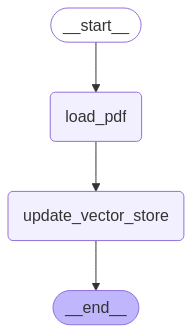

In [7]:
from IPython.display import Image, display

display(Image(pdf_process_graph.get_graph().draw_mermaid_png()))

In [ ]:
with gr.Blocks(title="IZTECH Telecom RAG Server 🤖", theme=gr.themes.Soft()) as demo:   
    with gr.Tabs():
        # PDF Upload Tab
        with gr.TabItem("PDF Upload"):
            
            with gr.Row():
                gr.Markdown("Upload PDF files to update the vector database with new documents. Duplicate files will be skipped.")
            
            with gr.Row():
                pdf_input = gr.File(
                    file_count="multiple", 
                    file_types=['.pdf'], 
                    label="Upload PDF Files"
                )
            
            with gr.Row():
                process_btn = gr.Button("ADD to Vector DB")
                status_output = gr.Textbox(label="Processing Status", interactive=False)
            
            with gr.Row(elem_classes="center-row"):
                files_list = gr.DataFrame(
                    headers=["Filename", "Size (KB)", "Upload Date", "Actions"],
                    datatype=["str", "str", "str", "str"],
                    label="Uploaded PDFs",
                    interactive=False
                )

            delete_button = gr.Button("Delete Selected PDF")
            selected_pdf = gr.Textbox(visible=False)  # Hidden textbox for filename storage

            # Connect process button to process_pdfs function
            process_btn.click(
                fn=process_pdfs,
                inputs=[pdf_input],
                outputs=[status_output]
            ).then(
                fn=list_uploaded_files,
                outputs=[files_list]
            )

            # Select PDF from table for deletion
            files_list.select(
                fn=lambda row: row[0],  # Select filename
                outputs=[selected_pdf]
            )

            # Delete button callback
            delete_button.click(
                fn=delete_pdf,
                inputs=[selected_pdf],
                outputs=[files_list]
            )

            # Initialize the files list on page load
            demo.load(
                fn=list_uploaded_files,
                outputs=[files_list]
            )
        
        # Chat Tab
        with gr.TabItem("Chat"):
            chatbot = gr.ChatInterface(
                fn=respond,
                title="IZTECH-Server Telecom RAG Assistant 🤖",
            )
